In [298]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import pandas as pd
import pydotplus
import seaborn as sns

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

# Import `CSV` 

In [2]:
df = pd.read_csv('scraped_2018-09-05 15:43:57.539375')

In [3]:
df.tail()

,title,subreddit
1988,"Brett's mom, dad, and daughter brought to tear...",The_Donald
1989,Dick Durbin Admits: Democrats Plotted to Disru...,The_Donald
1990,Authorized and reauthorized 4 times without in...,The_Donald
1991,Wakey Wakey Lefties. You've been living in a d...,The_Donald
1992,Linda only protests in hopes of being manhandl...,The_Donald


In [4]:
df.shape

(1993, 2)

# Change `subreddit` categories to numerical values
> `politics == 1`

In [308]:
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'The_Donald' else 0)

In [6]:
df.iloc[1987,:]

title        WAHHHHHHHHH IM GOING HOME 😭😭 idiots. 🙄Democrat...
subreddit                                                    1
Name: 1987, dtype: object

# Train / Test Split

In [7]:
X = df['title']
y = df['subreddit']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y)

In [9]:
y_train.value_counts(normalize=True)

1    0.503347
0    0.496653
Name: subreddit, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

1    0.503006
0    0.496994
Name: subreddit, dtype: float64

In [11]:
y_train.shape

(1494,)

# Let's try a CountVectorizer because it's the first thing I imported and other reasons

In [12]:
cv = CountVectorizer(min_df=3, stop_words='english')

cv.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
X_train_cv = cv.transform(X_train)

In [14]:
train_set = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [15]:
train_set.head()

,000,10,100,11,13,14,15,20,2016,2018,...,wrote,year,years,yes,yesterday,york,yorker,young,youtube,zina
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_set['is_donald'] = y_train.values

In [17]:
train_set.shape

(1494, 1031)

# OR! we could have done this the easy way

In [249]:
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', min_df=3)),
    ('nb', MultinomialNB())
])

pipe.fit(X_train, y_train)

pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8781793842034806, 0.781563126252505)

# lets make some classes

In [255]:
class AverageWordLength(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def avg_word_length(self, line):
        return np.mean([len(each) for each in line.split()])
    
    def transform(self, df):
        return np.array(df.apply(self.avg_word_length)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [256]:
def count_hashes(line):
    return line.count('#')

In [257]:
class CountHashes(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def count_hashes(self, line):
        return line.count('#')
    
    def transform(self, df):
        return np.array(df.apply(self.count_hashes)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [260]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes())
    ])),
    ('nb', MultinomialNB())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9330655957161981, 0.7755511022044088)

# include compound score from VADER in pipe

In [300]:
class CompoundScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_compound(self, line):
        return sia.polarity_scores(line)['compound']
    
    def transform(self, df):
        return np.array(df.apply(self.get_compound)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [301]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore())
    ])),
    ('nb', LogisticRegression())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9846050870147256, 0.7955911823647295)

# add neg score from VADER to pipe

In [267]:
class NegScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_neg(self, line):
        return sia.polarity_scores(line)['neg']
    
    def transform(self, df):
        return np.array(df.apply(self.get_neg)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [268]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore()),
        ('ns', NegScore())
    ])),
    ('nb', LogisticRegression())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9846050870147256, 0.7955911823647295)

# add pos score from VADER to pipe

In [269]:
class PosScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_pos(self, line):
        return sia.polarity_scores(line)['pos']
    
    def transform(self, df):
        return np.array(df.apply(self.get_pos)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [271]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore())
    ])),
    ('nb', LogisticRegression())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9846050870147256, 0.8096192384769539)

# add neu score from VADER to pipe

In [272]:
class NeuScore(BaseEstimator, TransformerMixin):
    
    sia = SentimentIntensityAnalyzer()
    
    def __init__(self):
        pass
    
    def get_neu(self, line):
        return sia.polarity_scores(line)['neu']
    
    def transform(self, df):
        return np.array(df.apply(self.get_neu)).reshape(-1,1)
    
    def fit(self, df, y=None):
        return self

In [299]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('lcv', LogisticRegressionCV())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9953145917001339, 0.8036072144288577)

# lets try `KNN`

In [297]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('knn', KNeighborsClassifier())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.6512717536813922, 0.5731462925851704)

# lets try some tree stuff
> random forest

In [307]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('rf', RandomForestClassifier(n_estimators=500))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.998661311914324, 0.8296593186372746)

> decision tree

In [284]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('dc', DecisionTreeClassifier())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.998661311914324, 0.717434869739479)

> extra trees

In [291]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('et', ExtraTreesClassifier())
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.998661311914324, 0.7995991983967936)

# support vector

In [288]:
pipe = Pipeline([
    ('fu', FeatureUnion([
        ('cv', CountVectorizer()),
        ('awl', AverageWordLength()),
        ('ch', CountHashes()),
        ('cs', CompoundScore()),
        ('ns', NegScore()),
        ('ps', PosScore()),
        ('ne', NeuScore())
    ])),
    ('sv', SVC(C=100))
])

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8975903614457831, 0.7895791583166333)

# find the 15 most used words in all titles and cast to list

In [1]:
top_words = list(train_set.drop(['is_donald'], axis=1).sum().sort_values(ascending=False)[:15].index)

NameError: name 'train_set' is not defined

# stole this function from your EDA walkthrough

In [19]:
def plot_word_from_groupby(word, df=train_set, by='is_donald'):
    df.groupby(by).sum()[word].plot(kind='barh')
    plt.title(f'Occurences of {word.title()}')
    plt.show()

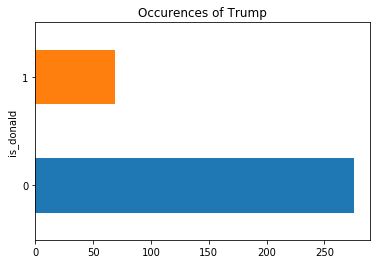

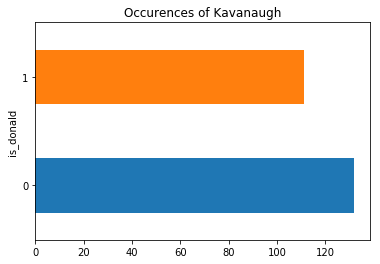

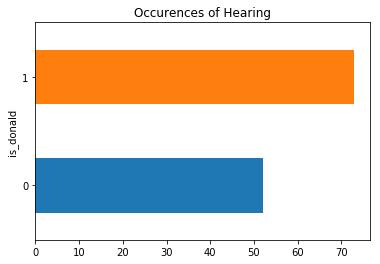

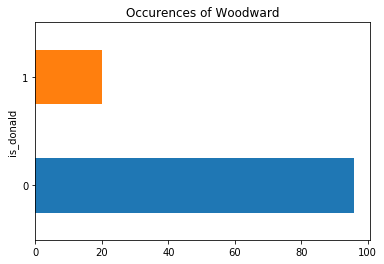

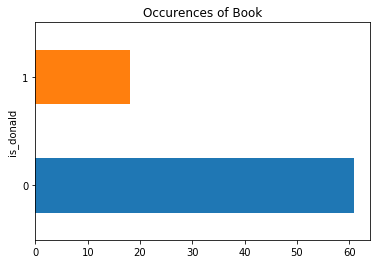

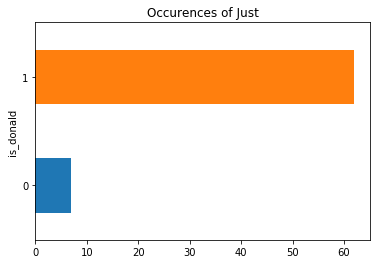

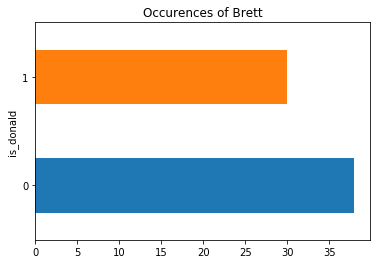

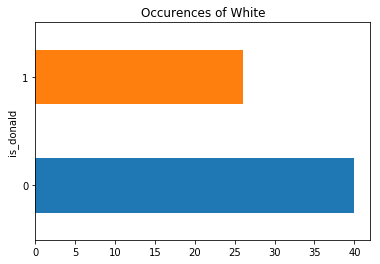

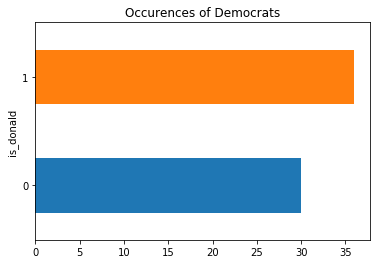

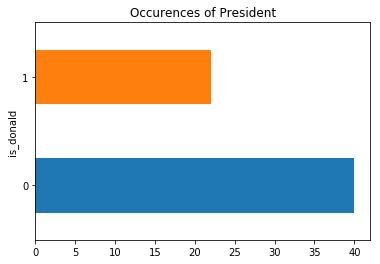

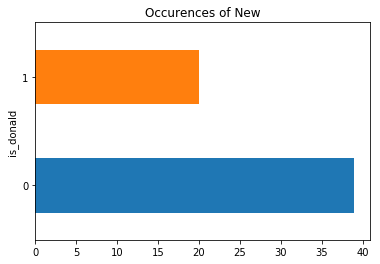

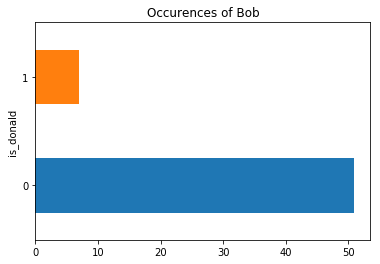

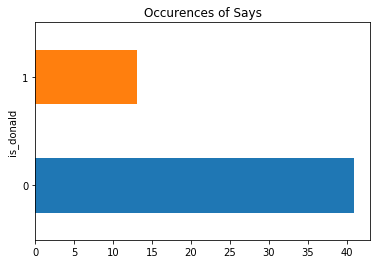

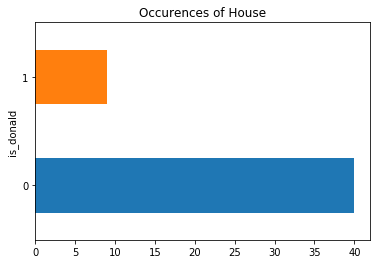

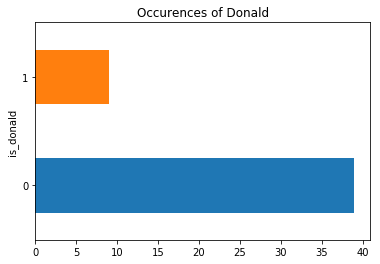

In [20]:
for word in top_words:
    plot_word_from_groupby(word)

# Try to make a word cloud
> top words in `r/the_donald` 

In [150]:
only_don = df[df['subreddit'] == 1]

In [151]:
lst = []
for each in only_don['title']:
    lst.append(each)

In [152]:
lst = str(lst)

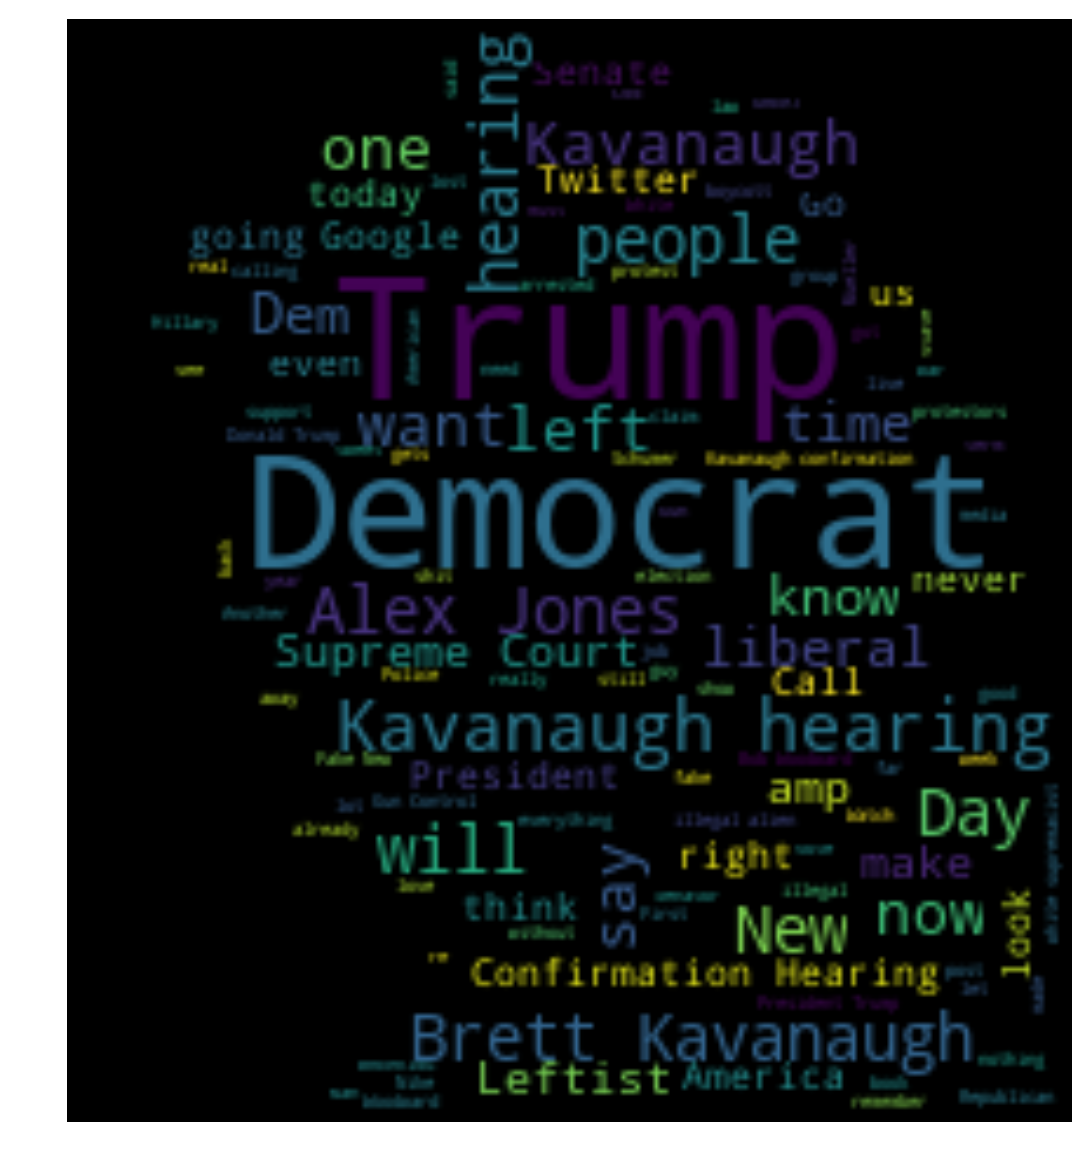

In [310]:
wave_mask = np.array(Image.open('./Images/trump3.jpg'))
 
# Make the figure
wordcloud = WordCloud(collocations=True,mask=wave_mask).generate(lst)
plt.figure(figsize=(9,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# let's see what this vader stuff is all about

In [21]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [23]:
sia = SentimentIntensityAnalyzer()

> Jon helped me out with this little for-loop to format the polarity_scores into a dataframe below

In [24]:
dicts = []

for post in df['title']:
    scores = sia.polarity_scores(post)
    scores['title'] = post
    dicts.append(scores)
df_vader = pd.DataFrame(dicts)
#df_vader = df_vader.drop_duplicates(['title'])

In [176]:
df_vader.columns

Index(['compound', 'neg', 'neu', 'pos', 'title', 'is_donald'], dtype='object')

In [25]:
df_vader['is_donald'] = df['subreddit'].values

In [68]:
half = 1993//2

df_vader.sort_values('pos', ascending=False)[:half]['is_donald'].sum()

623

In [69]:
623/996

0.6255020080321285

> 62.55% of the top 50% most "positive" posts are from `r/the_donald`

# It seems that `r/the_donald` has a higher rate of positivity overall
> this is probably due to the fact that `r/the_donald` is a subreddit that serves as an echo chamber for staunch trump supporters - they have less to complain about
# and `r/politics`  shows up a lot more often in the top 50% of negative sentiments
> in the exact opposite fashion of `r/the_donald`, `r/politics` has A LOT to complain about

In [72]:
df_vader.sort_values('neg', ascending=False)[:half]['is_donald'].sum()

516